In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers
from load_llff import load_llff_data

Args:
expname = linemod_driller_back_to_eggbox_similar_layout
basedir = ./logs
datadir = ./data/linemod_driller_back_to_eggbox_similar_layout
dataset_type = llff

factor = 1
llffhold = 8

N_rand = 1024
N_samples = 64
N_importance = 64

use_viewdirs = True
raw_noise_std = 1e0


Loaded image data (480, 640, 3, 51) [480.         640.         584.02774702]
Loaded ./data/linemod_driller_back_to_eggbox_similar_layout 2.89808077728652 133.50764495812902
recentered (3, 5)
[[ 1.0000000e+00 -1.5770741e-09  5.6356264e-08  1.6362060e-08]
 [ 1.5770742e-09  1.0000000e+00 -2.2803113e-09  1.6362060e-08]
 [-5.6356264e-08  2.2803113e-09  1.0000000e+00 -5.8435928e-10]]
Data:
(51, 3, 5) (51, 480, 640, 3) (51, 2)
HOLDOUT view is 41
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Found ckpts ['./logs/linemod_driller_back_to_eggbox_similar_layout/model_680000.npy']
Reloading from ./logs/linemod_driller_back_to_eggbox_si

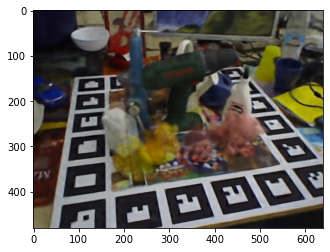

In [2]:
basedir = './logs'
expname = 'linemod_driller_back_to_eggbox_similar_layout'

exp_dir = os.path.join(basedir, expname) 

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, f'model_{680000}.npy'))
args = parser.parse_args('--config {} '.format(config) + ft_str)

images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor, 
                                                          recenter=True, bd_factor=.75, 
                                                          spherify=args.spherify)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(0., tf.float32),
    'far' : tf.cast(1., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

net_fn = render_kwargs_test['network_query_fn']
print(f'net_fn:{net_fn}')

# Render an overhead view to check model was loaded correctly
# c2w = poses[-1]
# print(c2w)
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
c2w[2, -1] = 0.
H, W, focal = 480, 640, 584.
down = 1
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

In [3]:
from create_linemod_data import LinemodLoader
jsons = LinemodLoader.load_jsons('/home/adam/shared/LINEMOD/nerf/driller_back_to_eggbox_similar_layout')

In [5]:
def output_image_and_matrix(input_c2w):
    print(input_c2w)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=input_c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    plt.imshow(img)
    plt.show()

In [6]:
flip_about_x_axis = np.eye(4)
flip_about_x_axis[1, 1] = -1.
flip_about_x_axis[2, 2] = -1.

def convert_to_opengl(transformation):
    open_gl_transformation = np.array([[0.,  1.,  0.,  0.],[0.,  0., -1.,  0],[-1.,0.,0.,0],[0.,0.,0.,1.]])
    return transformation @ open_gl_transformation

def transform_transformation(transformation, transform):
    answer = np.zeros_like(transformation, dtype=np.float32)
    answer[:3, :3] = transformation[:3, :3] @ transform[:3, :3]
    answer[:3, 3] = transformation[:3, 3].T @ transform[:3, :3]
    return answer

In [15]:
def get_lm_T(test_train, frame_number):
    return np.array(jsons[test_train]['frames'][frame_number]['transform_matrix'], dtype=np.float32)

In [19]:
def get_llff_T(frame_number):
    return np.r_[poses[frame_number, :4, :4],[[0.,0.,0.,1.]]].astype(np.float32)

In [16]:
T_n_341 = get_llff_T(1)
T_lm_341 = get_lm_T('test', 1)
T_convert = np.linalg.inv(T_lm_341) @ T_n_341

[[ 0.9566446   0.09659488  0.27477384  1.2854632 ]
 [-0.01970685  0.96270823 -0.26982287 -1.1705594 ]
 [-0.29059055  0.25270966  0.92287314  0.44423884]]


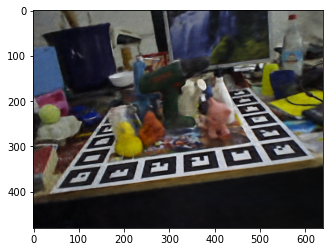

[[ 0.7286896  -0.41976613  0.54111665  1.8362924 ]
 [ 0.62946653  0.72178507 -0.2877465  -0.21402875]
 [-0.26978406  0.55029356  0.79018563  0.06792271]]


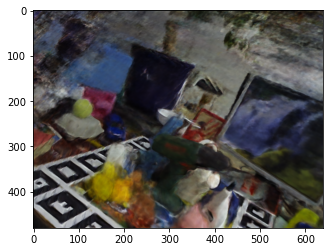

[[ 0.95664454  0.09659489  0.27477384  1.2854631 ]
 [-0.01970684  0.96270823 -0.2698229  -1.1705594 ]
 [-0.29059058  0.2527097   0.9228732   0.44423884]]


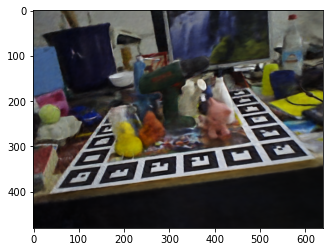

In [22]:
c2w_lm = get_lm_T('test', 1) @ T_convert.astype(np.float32)
output_image_and_matrix(c2w_lm[:3])

c2w_train = get_lm_T('test', 2) @ T_convert.astype(np.float32)
output_image_and_matrix(c2w_train[:3])

output_image_and_matrix(get_llff_T(1)[:3])


In [21]:
T_lm_341_inv = np.linalg.inv(get_lm_T('test', 1))
T_convert_inv = np.linalg.inv(T_lm_341_inv) @ T_lm_341_inv

[[ 0.95664454  0.09659488  0.2747738   1.2854631 ]
 [-0.01970682  0.96270823 -0.26982287 -1.1705594 ]
 [-0.29059058  0.2527097   0.92287314  0.4442389 ]]


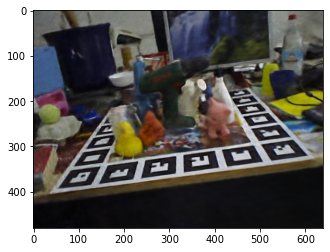

In [23]:
c2w_lm_inv = T_lm_341_inv @ T_convert_inv.astype(np.float32)
output_image_and_matrix(c2w_lm_inv[:3])

[[ 0.5826633  -0.01043235  0.8126466   2.0916448 ]
 [ 0.36466235  0.896967   -0.24994633 -0.7302819 ]
 [-0.72630894  0.44197565  0.52643347 -0.8004295 ]]


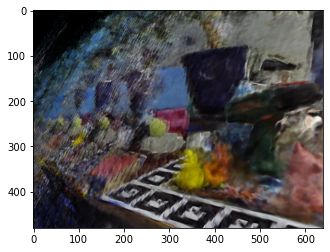

In [24]:
c2w_lm_inv_2 = np.linalg.inv(get_lm_T('test', 2)) @ T_convert_inv.astype(np.float32)
output_image_and_matrix(c2w_lm_inv_2[:3])